# Scaling EconML Using Ray 
[Ray](https://docs.ray.io/en/latest/index.html) is an open-source distributed computing framework that allows you to easily parallelize and scale your Python applications. It's designed to make it simple to write efficient, high-performance, and scalable code for various workloads, including machine learning, deep learning, data processing, and more. Ray provides a range of tools and libraries to manage distributed computing tasks, making it easier to utilize resources efficiently and speed up the execution of your code.

Our library calculates the nuisance estimators using cross-fitting for robustness. By default, the cross-fit operation is computed sequentially, which is suitable for smaller datasets. However, when dealing with large datasets, sequential computation may not be efficient and can take a long time. To address this challenge of scaling Ortholearners with large datasets or increasing Folds for cross-validation, our Package seamlessly integrates with the Ray library. This integration allows for parallelization of the cross-fit operations by utilizing Ray remote functions, known as Ray tasks. With this approach, each of the K folds can be invoked remotely and asynchronously on separate Python workers.


<div>
    <img src="images/seq_cv.png" style="width: 500px; height: 250px; display: block; border: 1px solid black; margin-bottom: 20px;">
</div>

<div>
    <img src="images/ray_parellel_cv.png" style="width: 500; height: 250px; display: block; border: 1px solid black;">
</div>

## Imports

In [4]:
import ray
import numpy as np
import scipy
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

## Ray Setup

In [5]:
# Initialize Ray
ray.init()


2023-08-17 00:02:20,082	INFO worker.py:1621 -- Started a local Ray instance.
2023-08-17 00:02:20,284	INFO packaging.py:518 -- Creating a file package for local directory '/Users/vishal.verma/Projects/poc/personal/EconML-Ray/notebooks'.
2023-08-17 00:02:20,359	INFO packaging.py:346 -- Pushing file package 'gcs://_ray_pkg_0eadd018dd5d6e1e.zip' (8.52MiB) to Ray cluster...
2023-08-17 00:02:20,383	INFO packaging.py:359 -- Successfully pushed file package 'gcs://_ray_pkg_0eadd018dd5d6e1e.zip'.


Python version:,3.9.12
Ray version:,2.6.2


## Synthetic Data
To demonstrate scaling using ray we will generate a synthetic dataset

In [5]:
np.random.seed(123)
n = 5000
X = np.random.normal(size=(n, 5))
T = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = (1 + .5*X[:, 0]) * T + X[:, 0] + np.random.normal(size=(n,))

## Using the SDK
In the econml package, function `_crossfit`  is implemented in the `_OrthoLearner` class, and any estimator having baseclass as `_OrthoLearner` has option to use the parallel computation using Ray which can be used in following way .

1. Set the flag use_ray to True:
    * All the estimators having base class as `_OrthoLearner` takes an argument `use_ray` , which is set to `False` by default and can be set to `True` in order to leverage the Ray's parallel processing
2. Pass Ray Remote function options:
    * To optimize the performance of the Ray Remote task , argument `ray_remote_func_options` which taked input in form of dict (default {}) , can be passed to esitmator. (https://docs.ray.io/en/latest/ray-core/api/doc/ray.remote.html)

    
We will be using DML estimator for our demonstration in this notebook

In [6]:

ray_opts = {'num_cpus':2,'scheduling_strategy':'SPREAD'}

est = LinearDML(
    model_y=RandomForestRegressor(random_state=0),
    model_t=RandomForestClassifier(random_state=0),
    discrete_treatment=True,
    use_ray=True, #setting use_ray flag to True to use ray.
    ray_remote_func_options=ray_opts,
    cv=2, #Determines the cross-validation splitting strategy
    mc_iters=2 # The number of times to rerun the first stage models to reduce the variance of the nuisances.
               # Note: When use_ray=True will also parallelize the iteration depending upon the ray cluster config.
)

est.fit(y, T, X=X, W=None)
est.effect(X)


array([0.45315363, 1.6549579 , 0.91669949, ..., 1.16562133, 0.16146495,
       0.95911527])

## Performance Comparison 
We will compare the runtime of DML esitmator varying with different values of CV , to see the how using ray can significantly speed up the results.

In [15]:
import time
import matplotlib.pyplot as plt
import numpy as np


def compare_runtime(cv_values, use_ray=True):
    runtimes = []
    for cv in cv_values:
        ray_opts = {'num_cpus': 2, 'scheduling_strategy': 'SPREAD'} if use_ray else None
        est = LinearDML(model_y=RandomForestRegressor(random_state=0),
                        model_t=RandomForestClassifier(random_state=0),
                        discrete_treatment=True,
                        use_ray=use_ray,
                        ray_remote_func_options=ray_opts,
                        cv=cv,
                        mc_iters=1)

        start_time = time.time()
        est.fit(y, T, X=X, W=None)
        runtime = time.time() - start_time
        runtimes.append(runtime)
    return runtimes



In [16]:
cv_values = [2,4, 8, 10]
runtime_ray = compare_runtime(cv_values, use_ray=True)
runtime_without_ray = compare_runtime(cv_values, use_ray=False)

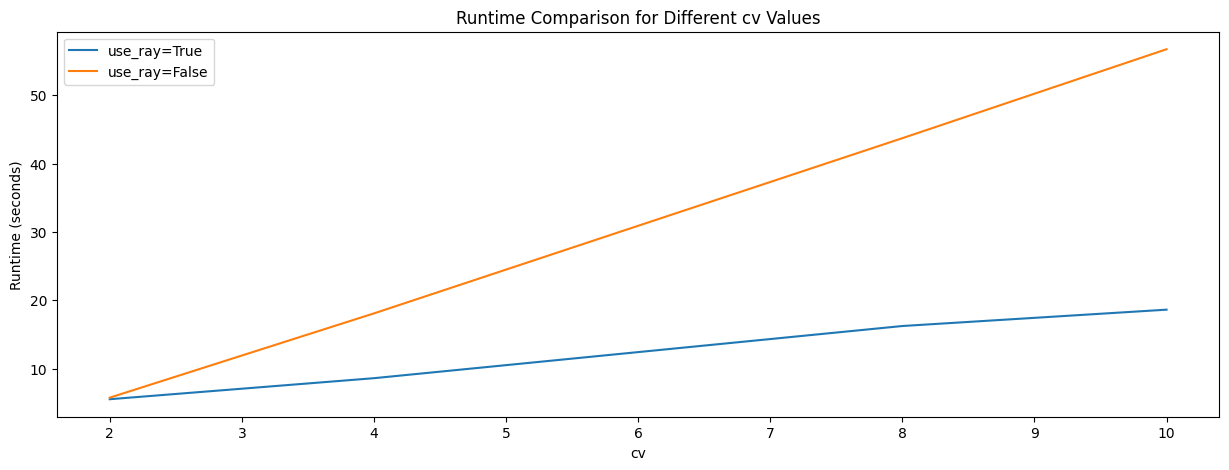

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(cv_values, runtime_ray, label='use_ray=True')
plt.plot(cv_values, runtime_without_ray, label='use_ray=False')
plt.xlabel('cv')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison for Different cv Values')
plt.legend()
plt.show()